# Handwritten Letters Classifier with PyTorch

<br>
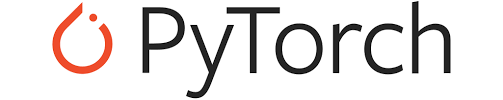

PyTorch is an open-source machine learning library for Python which allows maximum flexibility and speed on scientific computing for deep learning. 

## What is a Tensor?

A tensor, in mathematical terms, can be a matrix or a vector and in programming terms, is a NumPy array (for fellow Python readers). While doing ML/DL, your data needs to be represented numerically so we can perform all sorts of mathematical operations on it and this is the basic purpose of a tensor.

**Why not a NumPy Array then?**

So as to harness the power of GPU's for tensors can be used on a GPU that supports CUDA to accelerate computing.

## So what are we doing today?

1. Convert input image to tensor
2. Load the tensor on the GPU
3. Feed it into the model
4. Get a prediction



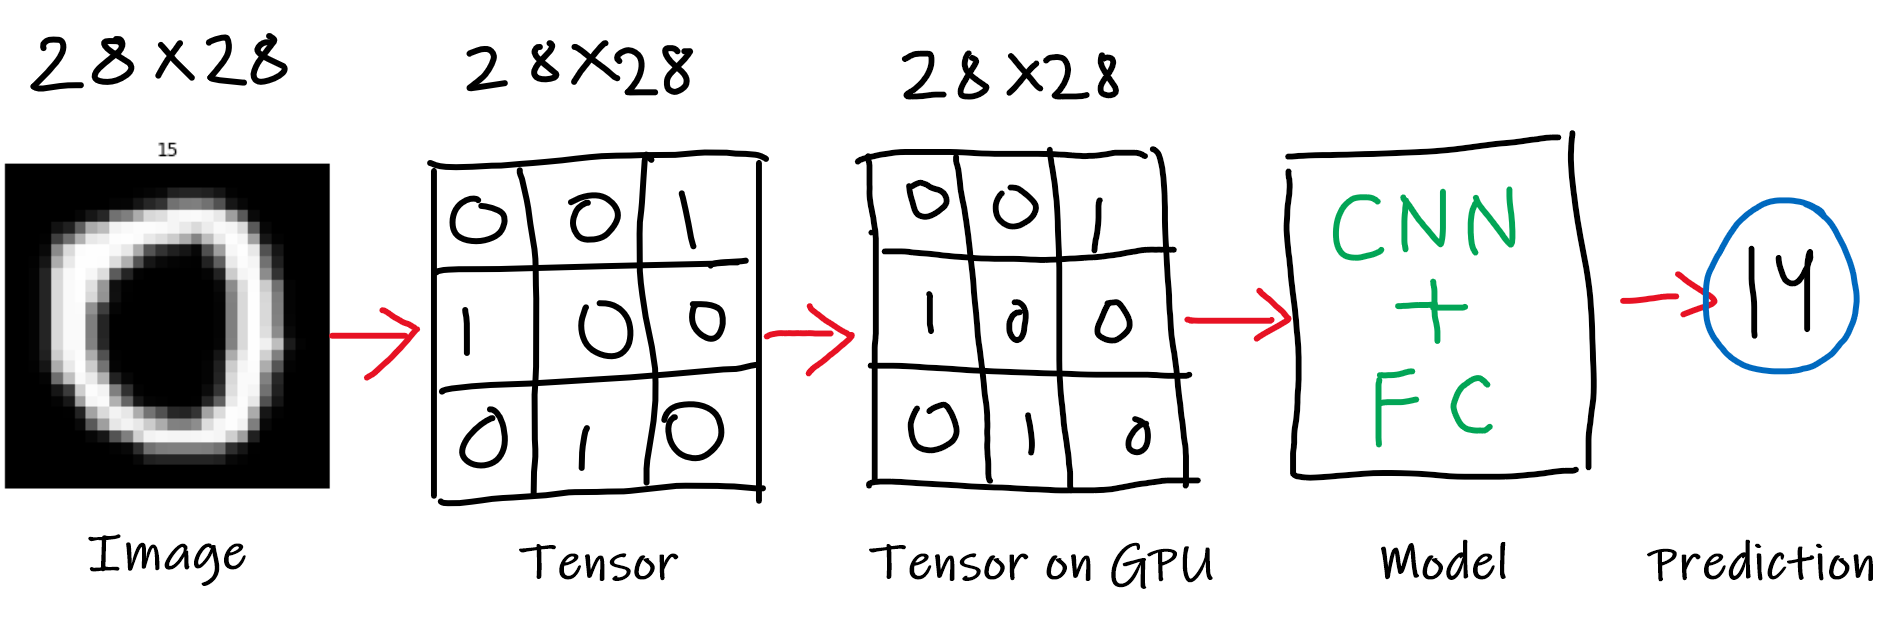

### How does the model predict?

**Training** - If we pass the image through the model and the result is not right, then we increase or decrease the parameters (weights and biases) of the model to nudge the model one step towards giving the right answer (minimise loss) and then we send the image through the model again.

### How do we know that the model's actually good?
**The need for a test dataset** - <br> 
We don't want a model that's learning the input data therefore we have a test set that contains data the model has never seen before and if the model achieves a good enough test accuracy, we can conclude that the model is working.


### How do you know when to stop training?

**The need for a validation dataset** - <br>
A validation dataset is a sample of data held back from training your model that is used to give an estimate of model skill while tuning model's parameters.

## Looking At The Data

### Imports

In [2]:
import torch  # PyTorch is based on the Torch library

from torch.utils.data.dataset import random_split
from torch.utils.data.dataloader import DataLoader

import torchvision
import torchvision.transforms as T  
from torchvision.datasets import EMNIST  # The dataset we will be working with
from torchvision.utils import make_grid

In [3]:
import matplotlib.pyplot as plt    # To plot the images and graphs
# To produce the output directly below the cell it is run
%matplotlib inline                 

### Downloading the EMNIST dataset available [here](https://pytorch.org/docs/stable/torchvision/datasets.html#emnist)

In [4]:
train_dataset = EMNIST(root = '/', train = True, split = 'letters', transform = T.ToTensor(), download = True)

Extracting /EMNIST/raw/emnist.zip to /EMNIST/raw
Processing byclass


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


In [5]:
test_dataset = EMNIST(root = '/', train = False, split = 'letters', transform = T.ToTensor(), download = True)

### Taking a look at a sample

In [9]:
image, label = train_dataset[0]
image.shape

torch.Size([1, 28, 28])

So our image is a single channel (grayscale) 28 by 28 pixels image

### Multi class classification

Given an input, we are going to classify it into one of many classes.

In [10]:
input_size = 28*28  # size of the images
output_size = len(train_dataset.classes)  
input_size, output_size

(784, 26)

We are going to determine what class between **a-z** our input image belongs to.

### Plotting the Image

Text(0.5, 1.0, '23')

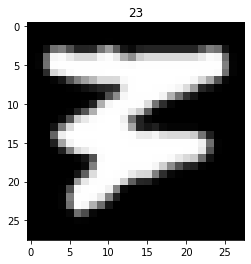

In [12]:
plt.imshow(image[0, :, :], cmap = 'gray') # We are plotting a 2D graph so we just need the 28*28 part
plt.title(label)

The images present are actually transposes of the original letter. To fix this, we are going to take the transpose of this image after we convert it to a tensor.

### Applying a custom transform when we download the dataset

In [15]:
class Transpose_Image:
    def __call__(self, tensor):
        return tensor.transpose(1,2)    # Interchanging the values at 1st and 2nd index

In [16]:
train_dataset = EMNIST(root = '/', train = True, split = 'letters', transform = T.Compose([T.ToTensor(), Transpose_Image()]), download = True)
test_dataset = EMNIST(root = '/', train = False, split = 'letters', transform = T.Compose([T.ToTensor(), Transpose_Image()]), download = True)

### Plotting the Image again

Text(0.5, 1.0, '23')

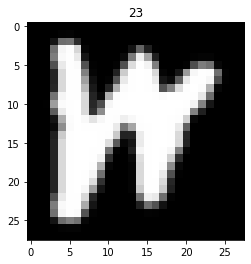

In [17]:
image, label = train_dataset[0]
plt.imshow(image[0, :, :], cmap = 'gray')
plt.title(label)

### Splitting into Train and Validation

In [19]:
random_seed = 42
# Sets the seed of the random number generator to a fixed value so as to produce reproducible results
torch.manual_seed(random_seed) 

In [20]:
val_size = 5000
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(119800, 5000)

### Setting a batch size

#### Batch Size
Number of samples that'll go through our model at once. <br>
**Advantages** -
1. Less memory usage
2. The model train's faster as parameters are updated after every mini batch

In [21]:
batch_size = 128

#### DataLoader

They help us to effectively manage these mini batches.

In [23]:
train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle = True, num_workers = 3, pin_memory = True) 
val_loader = DataLoader(val_ds, batch_size = batch_size, num_workers = 3, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, num_workers = 3, pin_memory = True)

- **shuffle** : The model sees a different batch of data everytime we train
- **num_workers** : Helps in parallelization while uploading data on the RAM
- **pin_memory** : Speeds up the host to device transfer when uploading the dataset on the GPU

### Taking look at a single batch

Shape of Images :  torch.Size([128, 1, 28, 28])


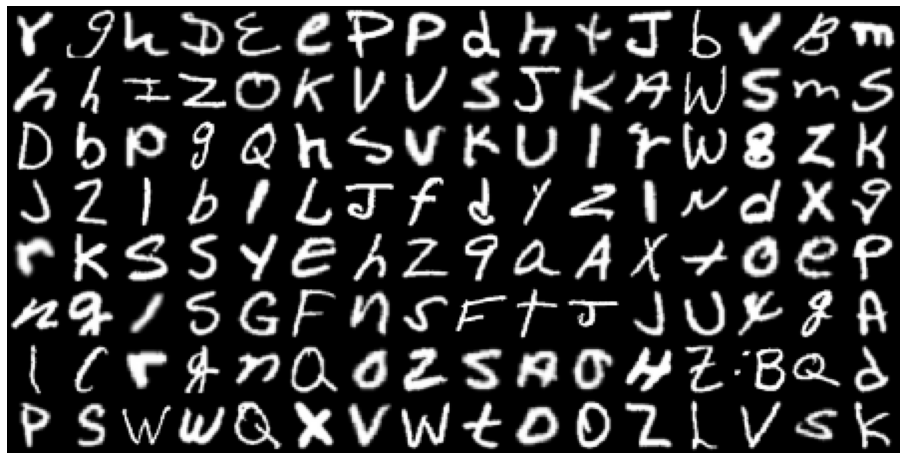

In [24]:
for images, labels in train_loader:
  print("Shape of Images : ", images.shape)
  plt.figure(figsize = (16, 16))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow = 16, padding = 0).permute(1, 2, 0))  # since the representation of NumPy arrays and Tensors are different
                                                                         # we have to change the shape from (1, 28, 28) -> (28, 28, 1)
  break

### Loading the DataLoader on the GPU

As datasets and models increase in size, the number of matrix multiplicaions performed can reach millions. And our computer CPUs designed for general purpose computing cannot handle these. Therefore we need GPUs to train our models in reasonable amount of time.

In [25]:
# Check if GPU's available and required CUDA drivers are installed or not
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

It isn't the DataLoader's job to send anything to the GPU. We have to load that data ourselves by calling `cuda()` which is stored in `device`.

In [26]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)   # Performance gain by transferring data asynchronously

Let's wrap our DataLoader in a class to move data to device

In [28]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for batch in self.dl:
      yield to_device(batch, self.device)   # Yield a batch of data after moving it to the device

  def __len__(self):
    return len(self.dl)                     # Number of batches

**Note** - We move the data in batches because -
1. The entire dataset might not fit on the GPU at once. 
2. We don't want the data that's not training to just occupy's the GPUs memory and sit idly.

In [30]:
train_ddl = DeviceDataLoader(train_loader, device)
val_ddl = DeviceDataLoader(val_loader, device)
test_ddl = DeviceDataLoader(test_loader, device)

## Models

### Our Model

Not an exact but similar representation of our model -


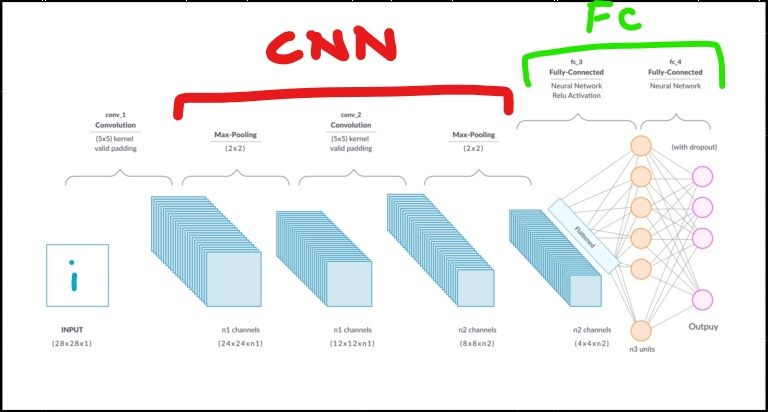

### Neural Networks

A simple fully connected neural network with 1 input layer, 1 output layer and 2 hidden layers. 

<img src="https://pbs.twimg.com/media/EbQ7PMyXYAAJSZg?format=png&name=900x900">

How the connections increase as number of nodes increase

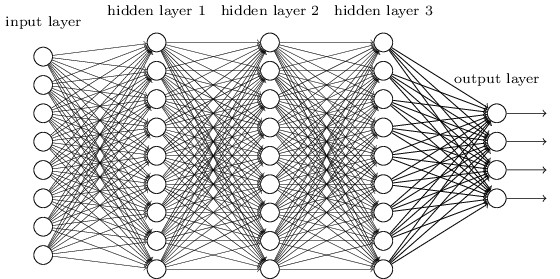

### Convolutional Neural Networks

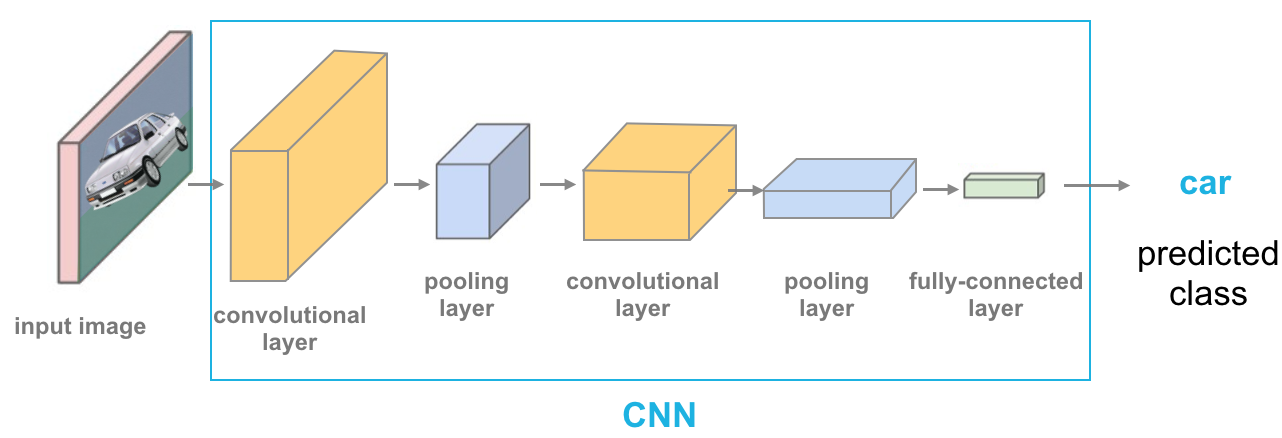

#### But first, what is a convolution?

<img src="https://miro.medium.com/max/803/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif">

#### Padding

<img src = "https://miro.medium.com/max/593/1*1okwhewf5KCtIPaFib4XaA.gif">

#### Striding

<img src= "https://miro.medium.com/max/441/1*BMngs93_rm2_BpJFH2mS0Q.gif">

#### Pooling

<img src="https://lh6.googleusercontent.com/WrwzzHg4myE4BSbDJjk2zaGaE51jcSJ2yEHoYTtJAISZ23bJMluTfI6J-0QzhJrFXVRDlBoLgmijONKLzfsX2jWf9u4SwfknMLHPUi8u9K2xzo9qOd5WhpnN1OC9rkG1WM9vBQ1co5g">

<img src ="https://lh5.googleusercontent.com/ufsQMymu9l0BP0-jpi0bX1HS_mhKFW-e_iAfdoP_DjOjMf9-DuPfc77hFPsF4QOmO2Q-cc5vU_NYPGDG3XSYnZw6b6LroA-fVvIbolnsBKce2mt8rCGjdtQlxfoZ6EL9FbguU96RGb4">

### Let's build our model!

#### Necessary Imports 

In [32]:
import torch.nn as nn               # Provides us with building blocks
import torch.nn.functional as F

The evaluation metric is accuracy.

In [33]:
def find_accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim = 1)                   # Takes the prediction with the maximum probability
  return ((preds == labels).sum()).item() / len(preds)     # Calculates the number of predictions that were correct

Cross Entropy Loss is our loss function which measures the performance of a classification model whose output is a probability value between 0 and 1.

In [34]:
class Base_Class(nn.Module):
  def training_batch(self, batch):
    images, labels = batch
    labels = to_device(torch.tensor([x-1 for x in labels]), device)
    outputs = self.forward(images)
    loss = F.cross_entropy(outputs, labels)
    return loss

  def validation_batch(self, batch):
    images, labels = batch
    labels = to_device(torch.tensor([x-1 for x in labels]), device)
    outputs = self.forward(images)
    loss = F.cross_entropy(outputs, labels).item()
    accuracy = find_accuracy(outputs, labels)
    return {'val_loss' : loss, 'val_accuracy' : accuracy}

  def validation_end_epoch(self, outputs):
    epoch_loss = sum([x['val_loss'] for x in outputs]) / len(outputs)
    epoch_accuracy = sum([x['val_accuracy'] for x in outputs]) / len(outputs)
    return {'epoch_loss' : epoch_loss, 'epoch_accuracy' : epoch_accuracy}

#### Model's Architecture

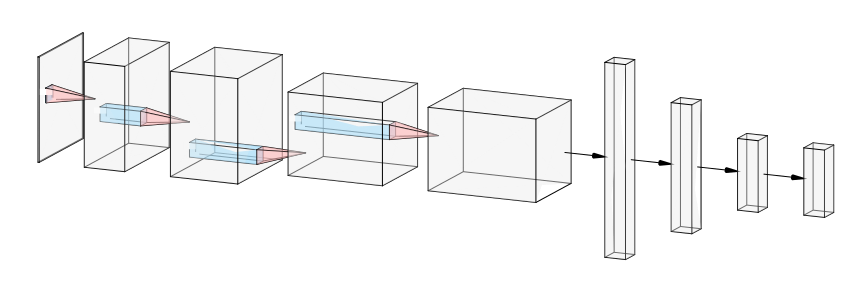

**RelU** - Activation Function to introduce non-linearity. <br>
**Batch Normalization** - Makes models faster and stable via normalization.

In [35]:
class EMNIST(Base_Class):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(1, 8, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(inplace=True),    # Inplace saves memory
        nn.BatchNorm2d(8),        # Normalize the activations across n channels
        nn.Conv2d(8, 32, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2), # 32*14*14 shape

        nn.Conv2d(32, 128, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(2), # 256*7*7 shape

        nn.Flatten(),             # Flatten the image for the linear layers
        nn.Linear(256*7*7, 512),
        nn.ReLU(),
        nn.Linear(512, 32),
        nn.ReLU(),
        nn.Linear(32, 26)
    )

  def forward(self, images):
    return self.network(images)

In [36]:
model = EMNIST()
to_device(model, device)

EMNIST(
  (network): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Flatten()
    (1

## Training and Validating

### For a Number of Epochs:

#### Training Phase

For a batch in train_ddl :
  1. Generate predictions
  2. Calculate loss
  3. Compute gradients
  4. Update weights
  5. Reset gradients

#### Validation Phase

For batch in val_ddl:
  1. Generate predictions
  2. Calculate loss
  3. Calculate accuracy

#### Display epoch loss and accuracy

**Epochs** - The number of times we train on the entire dataset. <br>
**Learning Rate** - By how much are we increasing/ decreasing the model's parameters. <br>
**Gradient** - The direction in which we need to nudge the model. We calculate this by calculating loss at each step.<br>
**Loss Function** - Loss is nothing but a prediction error of a model. And the method to calculate the loss is called Loss Function.<br>
**Optimization Function** - Algorithms used to change the model parameters and reduce the loss.


In [37]:
@torch.no_grad()
def validate(model, val_ddl):
  model.eval()
  outputs = [model.validation_batch(batch) for batch in val_ddl]
  return model.validation_end_epoch(outputs)

def fit(model, epochs, learning_rate, train_ddl, val_ddl, optimization_func = torch.optim.SGD):
  history = []
  optimizer = optimization_func(model.parameters(), learning_rate)
  for epoch in range(epochs):
    model.train()
    for batch in train_ddl:
      loss = model.training_batch(batch)
      loss.backward()                 # Feedback our model is receiving 
      optimizer.step()                # Update parameters
      optimizer.zero_grad()           # Clears old gradients otherwise we'd just accumulate previous gradients
    result = validate(model, val_ddl) 
    history.append(result)            # Storing the history
    print('Epoch: {}, Validation loss: {:.5f}, Validation accuracy: {:.5f}'.format(epoch, result['epoch_loss'], result['epoch_accuracy']))
  return history

### Validating on an untrained model 

In [38]:
history = [validate(model, val_ddl)]
history

[{'epoch_accuracy': 0.046875, 'epoch_loss': 3.263357710838318}]

### Training with different Learning Rates

In [39]:
history += fit(model, 5, 0.1, train_ddl, val_ddl)

Epoch: 0, Validation loss: 0.18634, Validation accuracy: 0.93965
Epoch: 1, Validation loss: 0.18544, Validation accuracy: 0.93496
Epoch: 2, Validation loss: 0.17494, Validation accuracy: 0.94336
Epoch: 3, Validation loss: 0.16602, Validation accuracy: 0.94004
Epoch: 4, Validation loss: 0.16620, Validation accuracy: 0.94941


In [40]:
history += fit(model, 5, 0.003, train_ddl, val_ddl)

Epoch: 0, Validation loss: 0.15513, Validation accuracy: 0.95117
Epoch: 1, Validation loss: 0.15477, Validation accuracy: 0.94785
Epoch: 2, Validation loss: 0.15387, Validation accuracy: 0.94844
Epoch: 3, Validation loss: 0.15415, Validation accuracy: 0.94980
Epoch: 4, Validation loss: 0.15453, Validation accuracy: 0.94766


In [41]:
history += fit(model, 5, 0.0001, train_ddl, val_ddl)

Epoch: 0, Validation loss: 0.15428, Validation accuracy: 0.94805
Epoch: 1, Validation loss: 0.15402, Validation accuracy: 0.94805
Epoch: 2, Validation loss: 0.15385, Validation accuracy: 0.94766
Epoch: 3, Validation loss: 0.15385, Validation accuracy: 0.94805
Epoch: 4, Validation loss: 0.15376, Validation accuracy: 0.94844


## Interpreting Results

### Plotting accuracy over multiple epochs

Text(0.5, 1.0, 'Accuracy vs No. of Epochs')

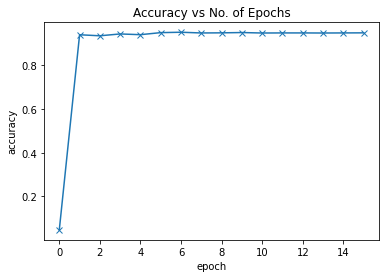

In [43]:
accuracies = [x['epoch_accuracy'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs No. of Epochs')

### Predicting on the Test Dataset

In [44]:
validate(model, test_ddl)

{'epoch_accuracy': 0.9479965490797546, 'epoch_loss': 0.15709652642910854}

## Saving the Model

In [45]:
torch.save(model.state_dict(), 'model.pth')